In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Global Measures

## Single Experiment

In [230]:
I = 30          # iterations
N_PEDS = 50     # percentage of pedestrians
N_CARS = 50     # percentage of cars
MODEL = "new"   # type of the model ('base' or 'new')

### Percentage of Evacuated

In [231]:
total_dfs = []
cars_dfs = []
peds_dfs = []

for i in range(1, I + 1):
    data = pd.read_csv(f"{base_folder}/evacuated/evacuated-{N_PEDS}-{N_CARS}-{i}.csv", skiprows=18)

    tot_evac = data[['x', 'y']].copy()
    tot_evac["i"] = i
    #tot_evac["cat"] = "evacuated"

    cars_evac = data[['x.1', 'y.1']].copy()
    cars_evac["i"] = i
    #cars_evac["cat"] = "cars"
    #cars_evac = cars_evac.rename(columns={'x.1':'x', 'y.1':'y'})

    peds_evac = data[['x.2', 'y.2']].copy()
    peds_evac["i"] = i
    #peds_evac["cat"] = "pedestrians"
    #peds_evac = peds_evac.rename(columns={'x.2':'x', 'y.2':'y'})

    # xx = pd.concat([tot_evac, cars_evac, peds_evac])

    #total_dfs.append(xx)

    total_dfs.append(tot_evac)
    cars_dfs.append(cars_evac)
    peds_dfs.append(peds_evac)

t_df = pd.concat(total_dfs).reset_index() # drop=True
c_df = pd.concat(cars_dfs).reset_index()
p_df = pd.concat(peds_dfs).reset_index()

KeyboardInterrupt: 

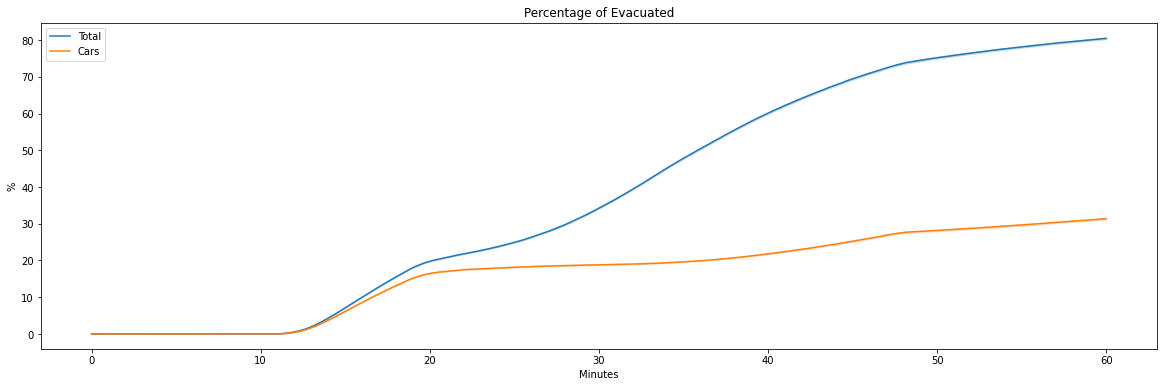

In [232]:
fig = plt.figure(figsize=(20, 6))
ax = sns.lineplot(x=t_df["x"], y=t_df["y"], label="Total") #  hue=t_df["cat"]
ax.set_title("Percentage of Evacuated")
ax.set_xlabel("Minutes")
ax.set_ylabel("%")
sns.lineplot(x=c_df["x.1"], y=c_df["y.1"], label="Cars")
sns.lineplot(x=p_df["x.2"], y=p_df["y.2"], label="Pedestrians")
fig.tight_layout()

### Casualties

In [ ]:
total_dfs = []
cars_dfs = []
peds_dfs = []

for i in range(1, I + 1):
    data = pd.read_csv(f"{base_folder}/casualties/casualties-{N_PEDS}-{N_CARS}-{i}.csv", skiprows=18)

    tot_evac = data[['x', 'y']].copy()
    tot_evac["i"] = i
    #tot_evac["cat"] = "evacuated"

    cars_evac = data[['x.1', 'y.1']].copy()
    cars_evac["i"] = i
    #cars_evac["cat"] = "cars"
    #cars_evac = cars_evac.rename(columns={'x.1':'x', 'y.1':'y'})

    peds_evac = data[['x.2', 'y.2']].copy()
    peds_evac["i"] = i
    #peds_evac["cat"] = "pedestrians"
    #peds_evac = peds_evac.rename(columns={'x.2':'x', 'y.2':'y'})

    # xx = pd.concat([tot_evac, cars_evac, peds_evac])

    #total_dfs.append(xx)

    total_dfs.append(tot_evac)
    cars_dfs.append(cars_evac)
    peds_dfs.append(peds_evac)

t_df = pd.concat(total_dfs).reset_index() # drop=True
c_df = pd.concat(cars_dfs).reset_index()
p_df = pd.concat(peds_dfs).reset_index()

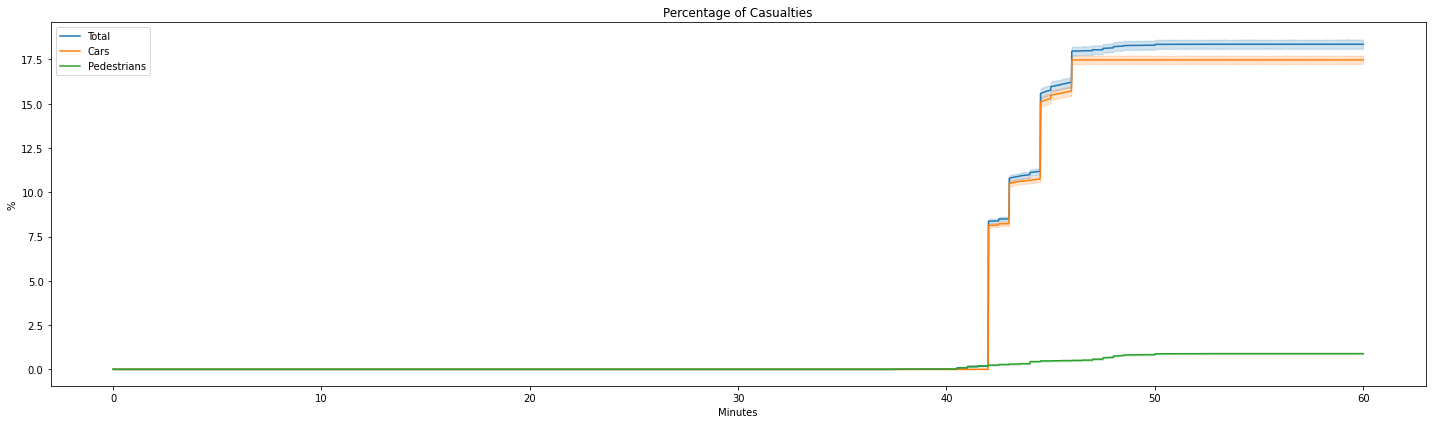

In [ ]:
fig = plt.figure(figsize=(20, 6))
ax = sns.lineplot(x=t_df["x"], y=t_df["y"], label="Total") #  hue=t_df["cat"]
ax.set_title("Percentage of Casualties")
ax.set_xlabel("Minutes")
ax.set_ylabel("%")
sns.lineplot(x=c_df["x.1"], y=c_df["y.1"], label="Cars")
sns.lineplot(x=p_df["x.2"], y=p_df["y.2"], label="Pedestrians")
fig.tight_layout()

### Evacuation Times

In [ ]:
# averaged times
df = pd.DataFrame({"y" : [0] * 60}, index=range(1, 61))

for i in range(1, I + 1):
    data = pd.read_csv(f"{base_folder}/times/times-{N_PEDS}-{N_CARS}-{i}.csv", skiprows=18)
    data = data[['x', 'y']].set_index("x")
    data = data.reindex(range(1, 61), fill_value=0)
    df = df + data

df = df / I
df = df.reset_index()
df.columns = ["x", "y"]

In [ ]:
# confidence interval
df = []
for i in range(1, I + 1):
    data = pd.read_csv(f"{base_folder}/times/times-{N_PEDS}-{N_CARS}-{i}.csv", skiprows=18)
    data = data[['x', 'y']].set_index("x")
    data['i'] = i
    data = data.reindex(range(1, 61), fill_value=0)
    df.append(data)
    
df = pd.concat(df).reset_index()

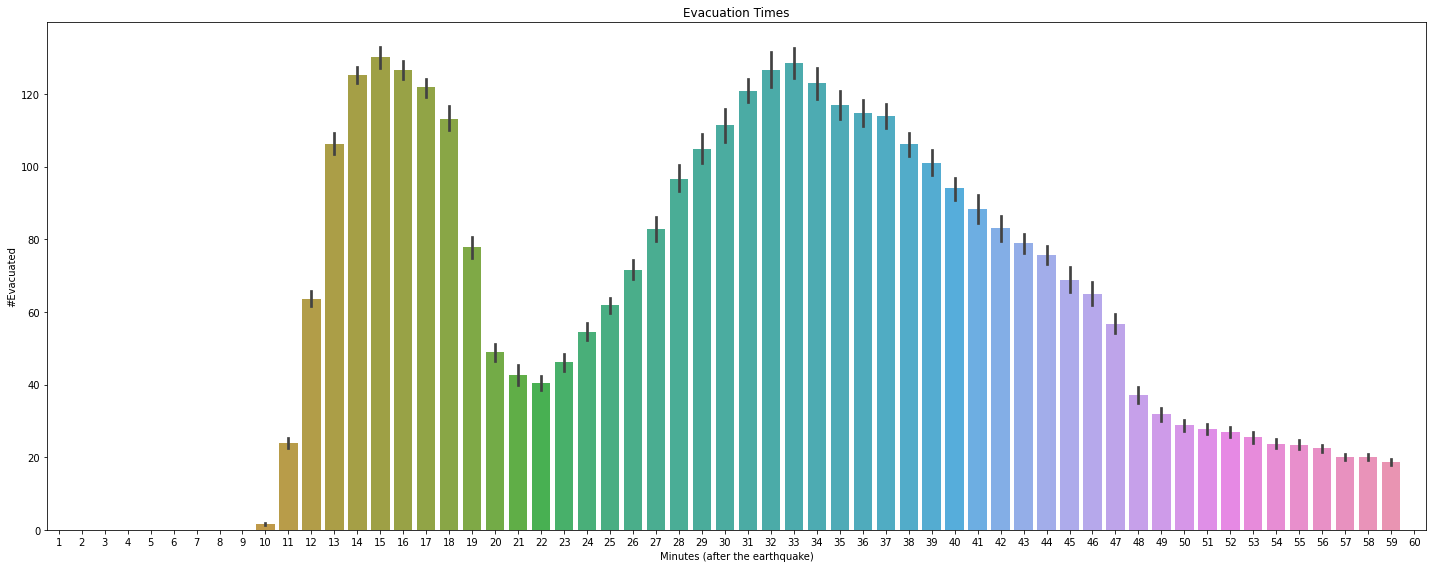

In [ ]:
fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x=df['x'], y=df['y'])
ax.set_title("Evacuation Times")
ax.set_xlabel("Minutes (after the earthquake)")
ax.set_ylabel("#Evacuated")
fig.tight_layout()

## Comparisons

In [203]:
I = 30          # iterations

exps = [
    { "N_PEDS": 0, "N_CARS": 100 },
    { "N_PEDS": 25, "N_CARS": 75 },
    { "N_PEDS": 50, "N_CARS": 50 },
    { "N_PEDS": 75, "N_CARS": 25 },
    { "N_PEDS": 100, "N_CARS": 0 },
]

models = ["base", "new"]

In [45]:
def plot_comparisons(model, measure, normalize=False):
    fig, axes = plt.subplots(1, 3, figsize=(20, 4), sharey=True, sharex=True)
    axes = axes.flatten()

    axes[0].set_title(f"Pedestrians")
    axes[0].set_xlabel("Minutes")
    axes[0].set_ylabel(f"% {measure.capitalize()}")
    axes[0].set_ylim([0, 100])

    axes[1].set_title(f"Cars")
    axes[1].set_xlabel("Minutes")
    axes[1].set_ylabel(f"% {measure.capitalize()}")
    axes[1].set_ylim([0, 100])

    axes[2].set_title(f"Total")
    axes[2].set_xlabel("Minutes")
    axes[2].set_ylabel(f"% {measure.capitalize()}")
    axes[2].set_ylim([0, 100])

    labels = [f"Pedestrians: {exp['N_PEDS']}%, Cars: {exp['N_CARS']}%" for exp in exps]

    for i, exp in enumerate(exps):
        avg_data = pd.DataFrame()
        for k in range(1, I + 1):
            data = pd.read_csv(f"./data/{model}/{measure}/{measure}-{exp['N_PEDS']}-{exp['N_CARS']}-{k}.csv", skiprows=18)
            data["i"] = k

            avg_data = pd.concat((data, avg_data))
        
        tot_avg_data = avg_data[["x", "y"]]
        car_avg_data = avg_data[["x.1", "y.1"]]
        ped_avg_data = avg_data[["x.2", "y.2"]]

        tot_groups = tot_avg_data.groupby(tot_avg_data.index)
        car_groups = car_avg_data.groupby(car_avg_data.index)
        ped_groups = ped_avg_data.groupby(ped_avg_data.index)

        tot_avg_data = tot_groups[["x", "y"]].mean()
        cars_avg_data = car_groups[["x.1", "y.1"]].mean()
        peds_avg_data = ped_groups[["x.2", "y.2"]].mean()
       
        if normalize:
            cars_avg_data["y.1"] = cars_avg_data["y.1"] / (exp['N_CARS'] / 100)
            peds_avg_data["y.2"] = peds_avg_data["y.2"] / (exp['N_PEDS'] / 100)

        lbl = f"Pedestrians: {exp['N_PEDS']}%, Cars: {exp['N_CARS']}%"
        
        if exp['N_PEDS'] != 0:
            sns.lineplot(peds_avg_data, x="x.2", y="y.2", ax=axes[0], label=lbl, legend=False)
        else:
            sns.lineplot(tot_avg_data, x="x", y=0, ax=axes[0], label=lbl, legend=False)
        
        if exp['N_CARS'] != 0:
            sns.lineplot(cars_avg_data, x="x.1", y="y.1", ax=axes[1], label=lbl, legend=False)
        else:
            sns.lineplot(tot_avg_data, x="x", y=0, ax=axes[1], label=lbl, legend=False)

        sns.lineplot(tot_avg_data, x="x", y="y", ax=axes[2], label=lbl, legend=False)
    
    handles, labels = axes[2].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels, loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=5)
    fig.tight_layout()

In [ ]:
plot_comparisons("base", "evacuated")
#plot_comparisons("new_const", "evacuated")
plot_comparisons("new", "evacuated")

In [ ]:
plot_comparisons("base", "casualties")
#plot_comparisons("new_const", "casualties")
plot_comparisons("new", "casualties")

In [58]:
def prova(models, measure, mode="total", normalize=False):
    skip_empty = normalize and mode != "total"
    N = 4 if skip_empty else 5

    fig, axes = plt.subplots(1, N, figsize=(25, 3), sharey=True, sharex=True)
    axes = axes.flatten()

    for model in models:
        for i in range(N):
            exp = exps[i]

            if skip_empty and mode == "pedestrians":
                exp = exps[i + 1]
            
            lbl = f"Pedestrians: {exp['N_PEDS']}%, Cars: {exp['N_CARS']}%"
            axes[i].set_title(lbl)

            # if measure == "casualties":
            #     axes[i].set_ylim([0, 40])

            avg_data = pd.DataFrame()
            for k in range(1, I + 1):
                data = pd.read_csv(f"./data/{model}/{measure}/{measure}-{exp['N_PEDS']}-{exp['N_CARS']}-{k}.csv", skiprows=18)
                data["i"] = k

                avg_data = pd.concat((data, avg_data))
            
            tot_avg_data = avg_data[["x", "y"]]
            car_avg_data = avg_data[["x.1", "y.1"]]
            ped_avg_data = avg_data[["x.2", "y.2"]]

            tot_groups = tot_avg_data.groupby(tot_avg_data.index)
            car_groups = car_avg_data.groupby(car_avg_data.index)
            ped_groups = ped_avg_data.groupby(ped_avg_data.index)

            tot_avg_data = tot_groups[["x", "y"]].mean()
            cars_avg_data = car_groups[["x.1", "y.1"]].mean()
            peds_avg_data = ped_groups[["x.2", "y.2"]].mean()
        
            if normalize:
                cars_avg_data["y.1"] = cars_avg_data["y.1"] / (exp['N_CARS'] / 100)
                peds_avg_data["y.2"] = peds_avg_data["y.2"] / (exp['N_PEDS'] / 100)

            if mode == "pedestrians":
                if exp['N_PEDS'] != 0:
                    sns.lineplot(peds_avg_data, x="x.2", y="y.2", ax=axes[i], label=model, legend=False)
                else:
                    sns.lineplot(tot_avg_data, x="x", y=0, ax=axes[i], label=model, legend=False)
            elif mode == "cars":
                if exp['N_CARS'] != 0:
                    sns.lineplot(cars_avg_data, x="x.1", y="y.1", ax=axes[i], label=model, legend=False)
                else:
                    sns.lineplot(tot_avg_data, x="x", y=0, ax=axes[i], label=model, legend=False)
            else:
                sns.lineplot(tot_avg_data, x="x", y="y", ax=axes[i], label=model, legend=False)
        
    handles, labels = axes[2].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels, loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=5)
    fig.tight_layout()

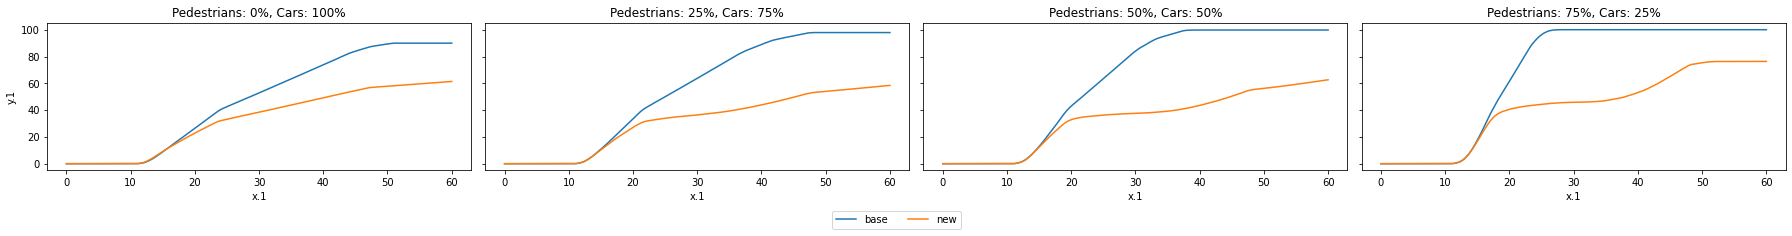

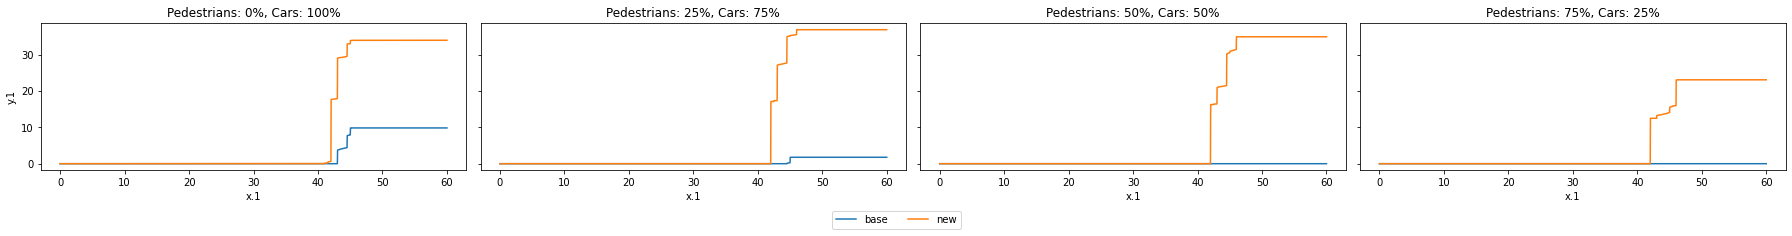

In [59]:
# cars
prova(models, "evacuated", mode="cars", normalize=True)
prova(models, "casualties", mode="cars", normalize=True)

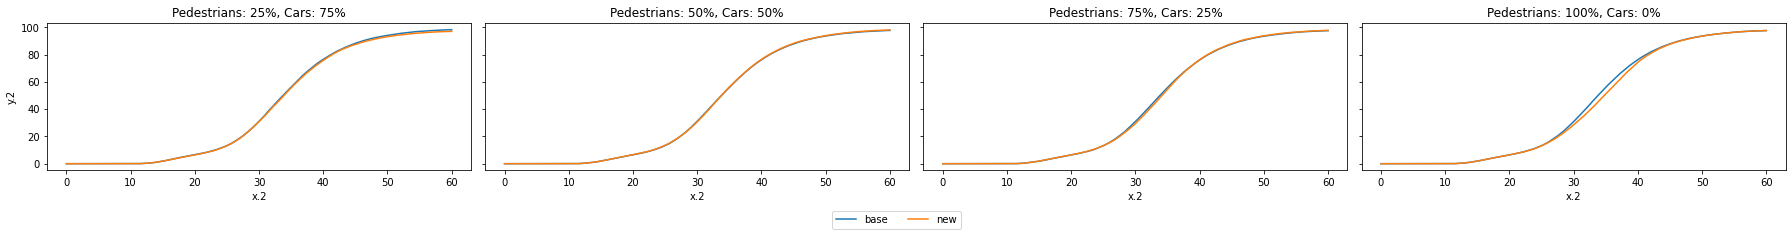

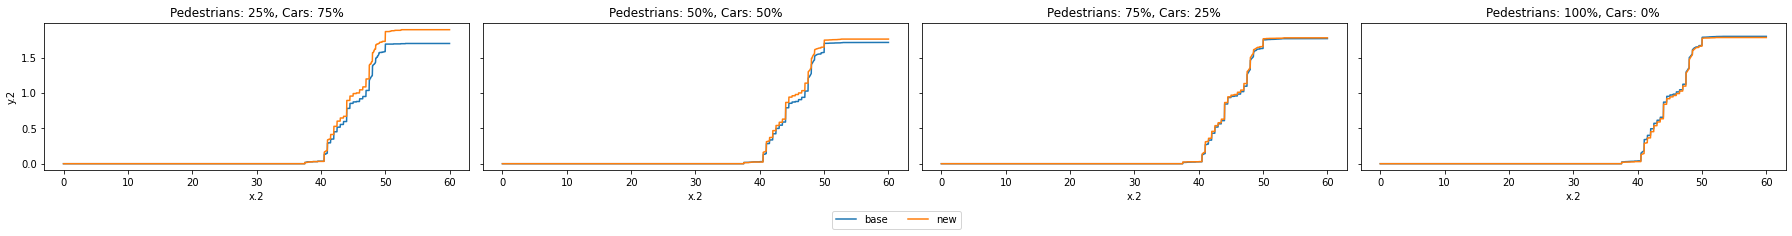

In [60]:
# pedestrians
prova(models, "evacuated", mode="pedestrians", normalize=True)
prova(models, "casualties", mode="pedestrians", normalize=True)

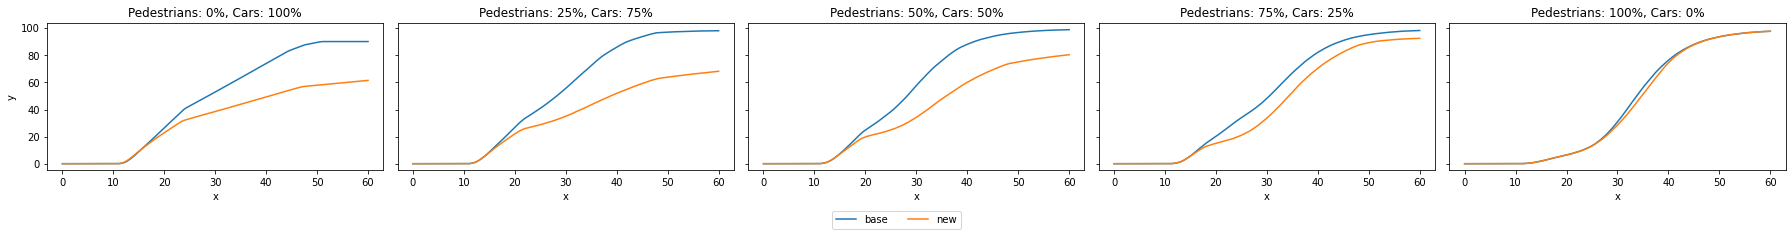

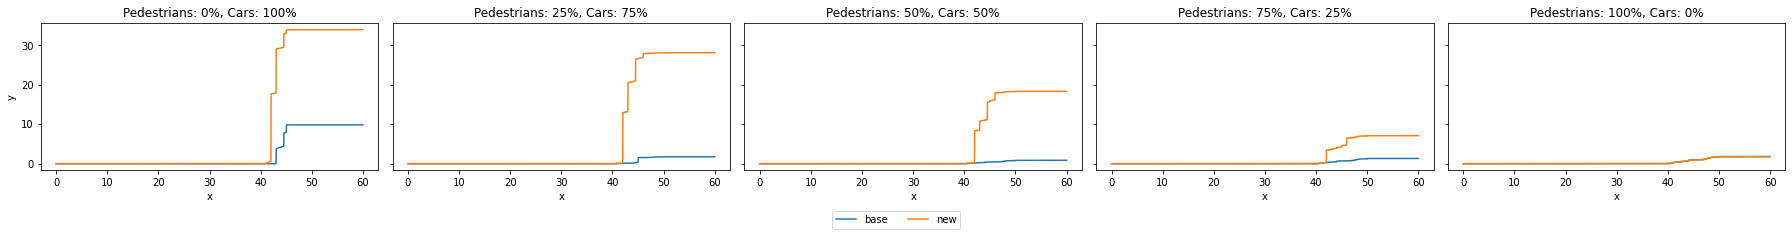

In [61]:
# total
prova(models, "evacuated", mode="total", normalize=False)
prova(models, "casualties", mode="total", normalize=False)

In [53]:
def plot_evacuation_times(models, mean=False):
    fig, ax = plt.subplots(len(exps), 1, figsize=(15, 10), sharex=True, sharey=True)
    ax = ax.flatten()

    for i, exp in enumerate(exps):
        
        for model in models:
            avg_data = None
            for k in range(1, I + 1):
                data = pd.read_csv(f"./data/{model}/times/times-{exp['N_PEDS']}-{exp['N_CARS']}-{k}.csv", skiprows=18)
                data = data[['x', 'y']].set_index("x")
                data = data.reindex(range(1, 61), fill_value=0)
                data = data.reset_index()
                
                if avg_data is None:
                    avg_data = data
                else:
                    avg_data = pd.concat((avg_data, data))

            if mean:
                groups = avg_data.groupby(avg_data.index)
                avg_evtimes_data = groups[["x", "y"]].mean()
                avg_evtimes_data["x"] = avg_evtimes_data["x"].astype(np.uint8)
                sns.lineplot(avg_evtimes_data, x="x", y="y", ax=ax[i], label=model)
            else:
                sns.lineplot(avg_data, x="x", y="y", ax=ax[i], label=model)

        lbl = f"Pedestrians: {exp['N_PEDS']}%, Cars: {exp['N_CARS']}%"
        
        ax[i].set_title(lbl)
        ax[i].set_xlabel("Minutes (after the earthquake)")
        ax[i].set_ylabel("# Evacuated")

    fig.tight_layout()

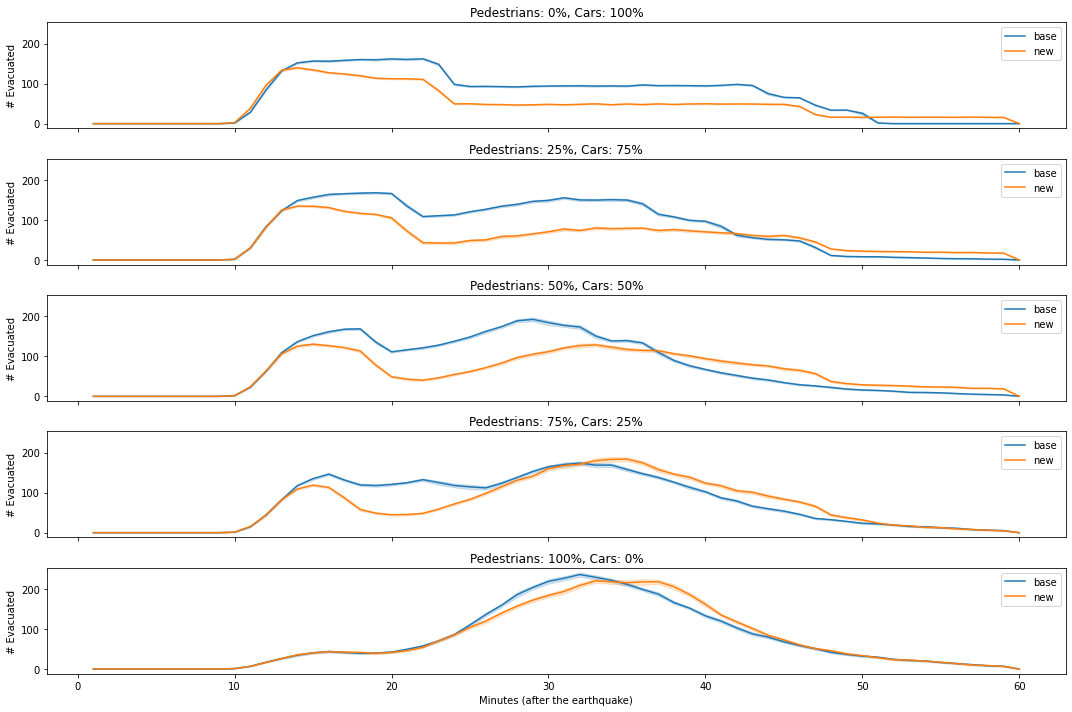

In [54]:
plot_evacuation_times(models)

In [55]:
def plot_comparisons(exps, normalize=True):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
    axes = axes.flatten()

    axes[0].set_xlabel("Minutes")
    axes[0].set_ylabel("% Cars")

    axes[1].set_xlabel("Minutes")
    axes[1].set_ylabel("% Pedestrians")

    axes[2].set_xlabel("Minutes")
    axes[2].set_ylabel("% Total")

    cars_data = pd.DataFrame()
    peds_data = pd.DataFrame()
    tot_data = pd.DataFrame()

    for i, exp in enumerate(exps):
        avg_data = pd.DataFrame()
        for k in range(1, I + 1):
            e_data = pd.read_csv(f"./data/{exp}/evacuated/evacuated-50-50-{k}.csv", skiprows=18)
            c_data = pd.read_csv(f"./data/{exp}/casualties/casualties-50-50-{k}.csv", skiprows=18)
            
            e_data["measure"] = "evacuated"
            c_data["measure"] = "casualties"

            data = pd.concat((e_data, c_data))
            data["i"] = k

            avg_data = pd.concat((data, avg_data))

        e_groups = avg_data[avg_data["measure"] == "evacuated"]
        e_groups = e_groups.groupby([e_groups.index])

        e_tot_avg_data = e_groups[["x", "y"]].mean()
        e_cars_avg_data = e_groups[["x.1", "y.1"]].mean()
        e_peds_avg_data = e_groups[["x.2", "y.2"]].mean()
        
        c_groups = avg_data[avg_data["measure"] == "casualties"]
        c_groups = c_groups.groupby([c_groups.index])

        c_tot_avg_data = c_groups[["x", "y"]].mean()
        c_cars_avg_data = c_groups[["x.1", "y.1"]].mean()
        c_peds_avg_data = c_groups[["x.2", "y.2"]].mean()

        e_tot_avg_data["measure"] = "evacuated"
        e_cars_avg_data["measure"] = "evacuated"
        e_peds_avg_data["measure"] = "evacuated"

        c_tot_avg_data["measure"] = "casualties"
        c_cars_avg_data["measure"] = "casualties"
        c_peds_avg_data["measure"] = "casualties"

        tot_avg_data = pd.concat((e_tot_avg_data, c_tot_avg_data))
        cars_avg_data = pd.concat((e_cars_avg_data, c_cars_avg_data))
        peds_avg_data = pd.concat((e_peds_avg_data, c_peds_avg_data))
        
        if normalize:
            cars_avg_data["y.1"] = cars_avg_data["y.1"] / (50 / 100)
            peds_avg_data["y.2"] = peds_avg_data["y.2"] / (50 / 100)

        cars_avg_data["experiment"] = exp
        peds_avg_data["experiment"] = exp
        tot_avg_data["experiment"] = exp

        cars_data = pd.concat((cars_avg_data, cars_data))
        peds_data = pd.concat((peds_avg_data, peds_data))
        tot_data = pd.concat((tot_avg_data, tot_data))

    sns.lineplot(x=cars_data["x.1"], y=cars_data["y.1"], hue=cars_data["measure"], ax=axes[0], style=cars_data["experiment"])
    sns.lineplot(x=peds_data["x.2"], y=peds_data["y.2"], hue=peds_data["measure"], ax=axes[1], style=peds_data["experiment"])
    sns.lineplot(x=tot_data["x"], y=tot_data["y"], hue=tot_data["measure"], ax=axes[2], style=tot_data["experiment"])

    fig.tight_layout()

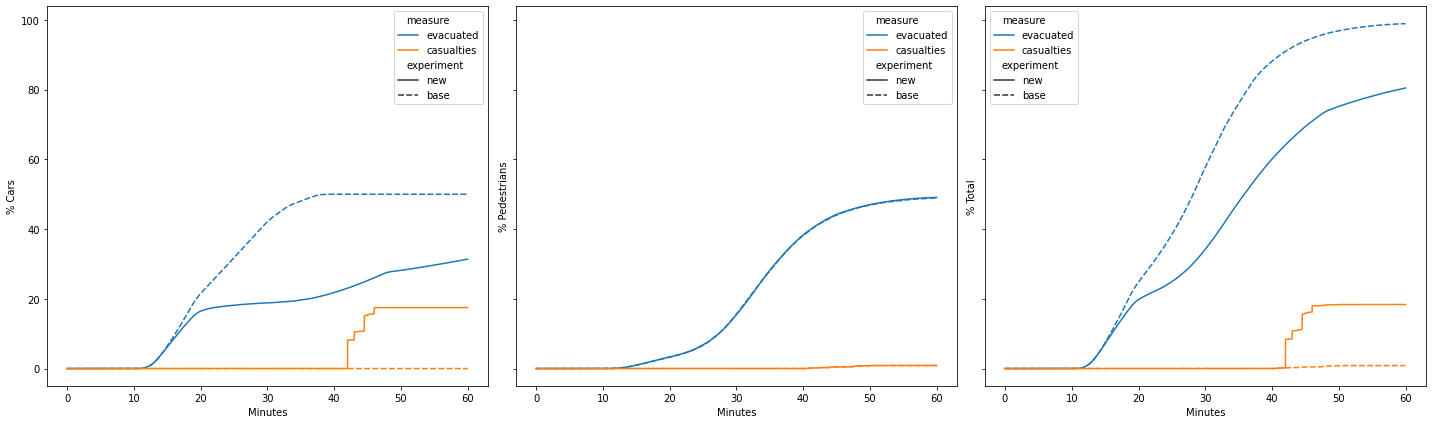

In [62]:
exps5050 = models

plot_comparisons(exps5050, normalize=False)

# Network Measures

## Average Values

In [31]:
import re

LIST_RE = re.compile(r"\[(\d+) (\d+(?:\.\d+)?)\]")


def parse_list(netlogo_list):
    x = LIST_RE.findall(netlogo_list)
    x = dict(map(list, x))

    return x


def to_netlogo(value):
    return "[" + " ".join([f"[{k} {v}]" for (k, v) in value.items()]) + "]" 


def average_netlogo_lists(lists):
    lists = list(map(parse_list, lists))
    
    # append values of the same intersection
    new_dict = {}
    for n in lists:
        for (key, value) in n.items():
            if key not in new_dict:
                new_dict[key] = []

            new_dict[key].append(float(value))

    # pad values if missing and replace values with the mean
    for (key, value) in new_dict.items():
        new_dict[key] = np.mean((np.pad(value, (0, I - len(value)))))

    return to_netlogo(new_dict)

In [32]:
def average_intersections(model, exp):
    prefix = f"./data/{model}/intersections/intersections-{exp['N_PEDS']}-{exp['N_CARS']}"

    ints_df = None
    for i in range (1, I + 1):
        data = pd.read_csv(f"{prefix}-{i}.csv")
        data = data.set_index(["who", "minute"])

        ints_df = pd.concat((ints_df, data))

    grouped_ints_df = ints_df.groupby(level=[0, 1])

    # average values 

    avg_ints_df = pd.DataFrame(grouped_ints_df["car-delay"].mean())

    for col in set(ints_df.columns) - set(["car-delay"]):
        avg_list = grouped_ints_df[col].apply(lambda x: average_netlogo_lists(x))
        avg_ints_df = avg_ints_df.join(avg_list)

    avg_ints_df.to_csv(f"{prefix}-mean.csv")

In [179]:
def average_intersections_evtimes(model, exp):
    prefix = f"./data/{model}/intersections/intersections-evtimes-{exp['N_PEDS']}-{exp['N_CARS']}"

    ints_evtime_df = None
    for i in range (1, I + 1):
        data = pd.read_csv(f"{prefix}-{i}.csv")
        data = data.set_index(["who"])

        ints_evtime_df = pd.concat((ints_evtime_df, data))

    ints_evtime_df = ints_evtime_df.groupby(level=[0]).mean()
    ints_evtime_df.to_csv(f"{prefix}-mean.csv")

In [34]:
def average_roads(model, exp):
    prefix = f"./data/{model}/roads/roads-{exp['N_PEDS']}-{exp['N_CARS']}"

    roads_df = None
    for i in range (1, I + 1):
        data = pd.read_csv(f"{prefix}-{i}.csv")
        data = data.set_index(["end1", "end2", "minute"])

        roads_df = pd.concat((roads_df, data))

    roads_df = roads_df.groupby(level=[0, 1, 2]).mean()

    roads_df.to_csv(f"{prefix}-mean.csv")

In [56]:
for model in models:
    for exp in exps:
        average_intersections(model, exp)
        average_intersections_evtimes(model, exp)
        average_roads(model, exp)

In [40]:
I = 3
model = "base_density"
exp = exps[4]

average_intersections(model, exp)
average_intersections_evtimes(model, exp)
average_roads(model, exp)

## Roads

### Casualties

In [57]:
def plot_critical_links(model, exps):
    fig, ax = plt.subplots(len(exps) + 1, 1, figsize=(15, 12), sharex=True, sharey=True)

    avg_casualties = []
    for i in range(len(exps) + 1):
        if i < len(exps):
            exp = exps[i]
            data = pd.read_csv(f"./data/{model}/roads/roads-{exp['N_PEDS']}-{exp['N_CARS']}-mean.csv")

            ints1 = set(data["end1"]) 
            ints2 = set(data["end2"])

            data = data.set_index(["end1", "end2"])
            data = data.loc[data["minute"] == 60]

            for x in ints1:
                for y in ints2:   
                    if (x, y) in data.index and (y, x) in data.index:
                        data.loc[(x, y)] = data.loc[(x, y)] + data.loc[(y, x)]
                        data.drop((y, x), inplace=True)

            data = data.reset_index()

            casualties = data["casualties"]
            avg_casualties.append(casualties)

            ax[i].set_title(f"Pedestrians: {exp['N_PEDS']}%, Cars: {exp['N_CARS']}%")
        else:
            casualties = np.mean(avg_casualties, axis=0)
            ax[i].set_title(f"Mean")

        ax[i].set_ylabel("% casualties")
        ax[i].set_xlabel("links")
        sns.lineplot(casualties / np.sum(casualties) * 100, ax=ax[i])

    fig.tight_layout()

    critical_links = data[casualties / np.sum(casualties) * 100 >= 5][["end1", "end2"]]
    critical_links["casualties"] = casualties[casualties / np.sum(casualties) * 100 >= 5]
    critical_links["casualties"] = np.round(critical_links["casualties"] / np.sum(casualties) * 100)
    critical_links["casualties"] = critical_links["casualties"].apply(lambda x : f"{x:.1f}%")
    
    return fig, critical_links

,end1,end2,casualties
233,128,250,22.0%
301,173,389,31.0%
323,188,214,6.0%
418,250,389,22.0%


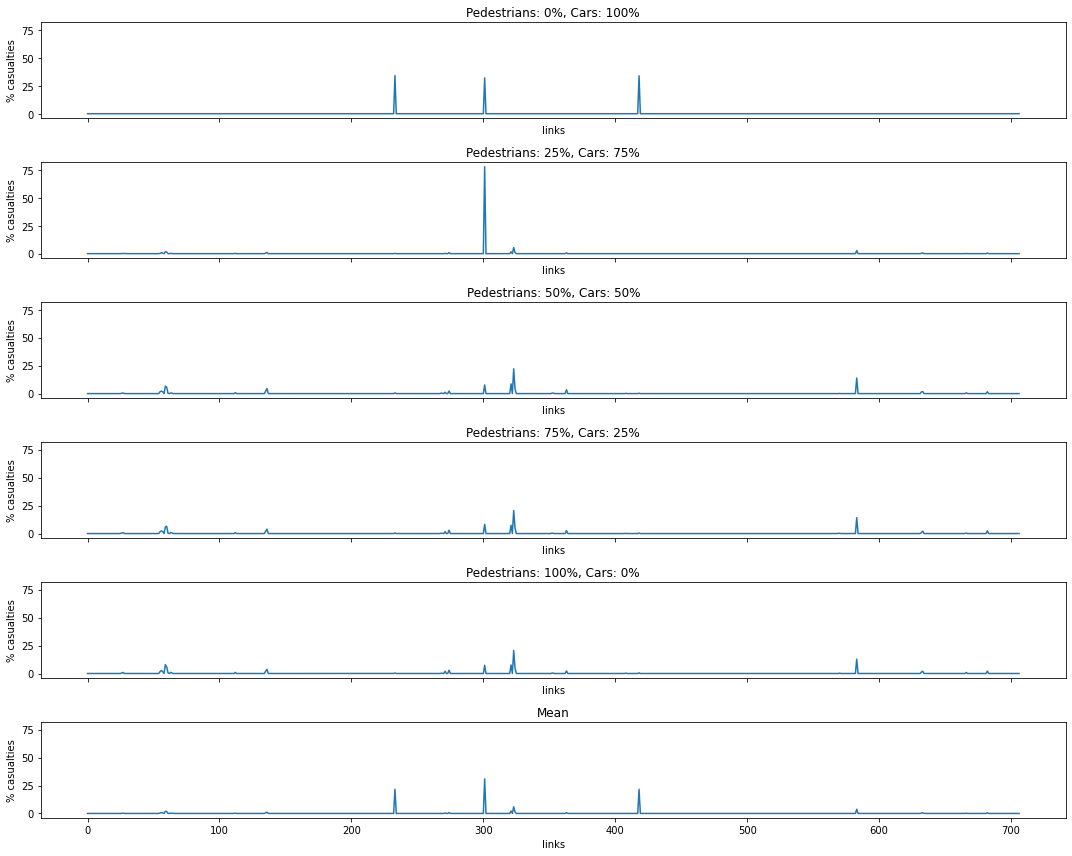

In [213]:
fig, critical_links = plot_critical_links("base", exps)
critical_links

,end1,end2,casualties
90,46,140,11.0%
232,128,129,12.0%
274,152,499,6.0%
352,201,280,15.0%
541,333,128,46.0%


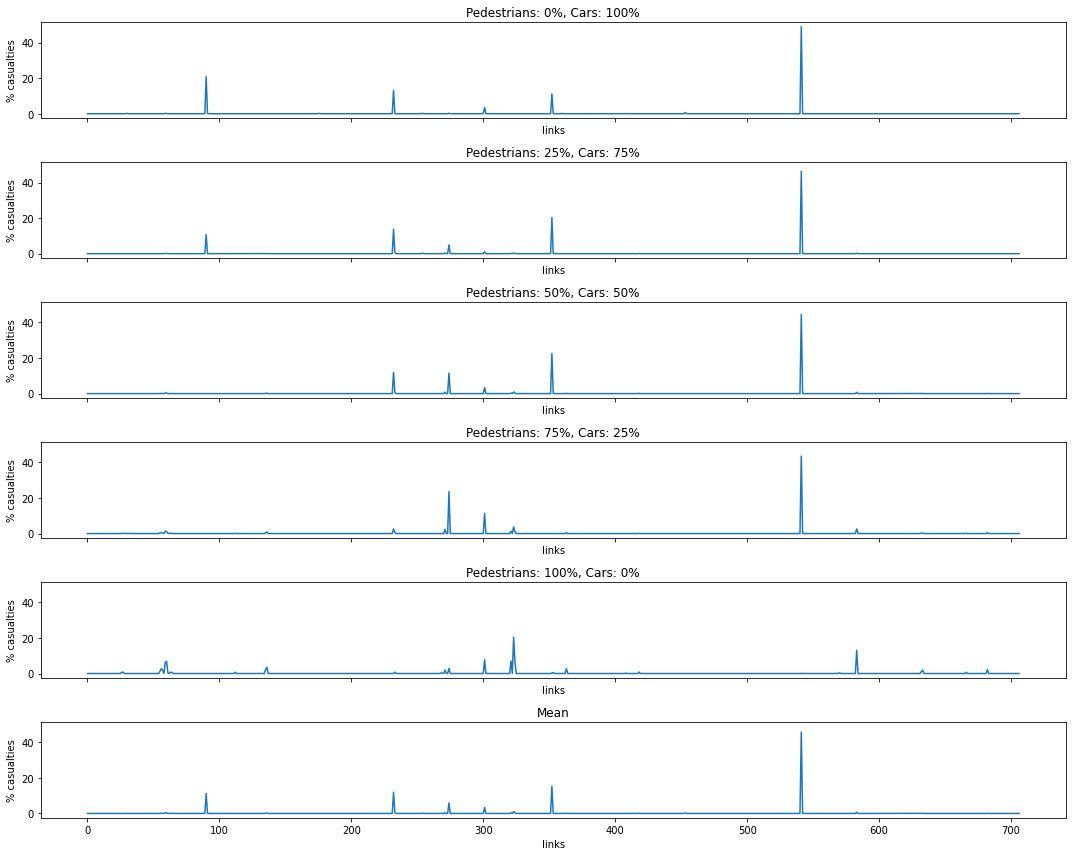

In [212]:
fig, critical_links = plot_critical_links("new", exps)
critical_links

## Intersections

In [120]:
two_way_df = pd.read_csv("../road_network/two-way.csv", header=None, names=["crossroads", "stop1", "stop2"])
two_way_df = two_way_df["crossroads"]
two_way_ints = set(two_way_df)

In [235]:
def plot_intersection_measure(model, exps):
    fig, ax = plt.subplots(len(exps) + 1, 1, figsize=(20, 12), sharex=True, sharey=True)

    avg_data = pd.DataFrame()
    for i, exp in enumerate(exps):
        data = pd.read_csv(f"./data/{model}/intersections/intersections-{exp['N_PEDS']}-{exp['N_CARS']}-mean.csv")

        data = data.set_index(["who"])
        data = data.loc[data["minute"] == 60]
        data.sort_index()
        data = data.reset_index()

        data["two-way?"] = data["who"].isin(two_way_ints).transform(lambda x: "TWSC" if x else "AWSC")

        avg_data = pd.concat((avg_data, data))

        ax[i].set_title(f"Pedestrians: {exp['N_PEDS']}%, Cars: {exp['N_CARS']}%")    
        sns.barplot(data, x="who", y="car-delay", hue="two-way?", order=data.sort_values(by="two-way?")["who"].values, ax=ax[i])    
        ax[i].set_ylabel("average delay (seconds)")
        ax[i].set_xlabel("intersections")
        ax[i].tick_params(axis='x', rotation=90)

    two_ways = data[["who", "two-way?"]].drop_duplicates()["two-way?"]

    avg_data = avg_data[["who", "car-delay"]].groupby("who").mean()
    avg_data = avg_data.reset_index()
    avg_data["two-way?"] = two_ways

    ax[i + 1].set_title(f"Mean")
    sns.barplot(avg_data, x="who", y="car-delay", hue="two-way?", order=avg_data.sort_values(by="two-way?")["who"].values, ax=ax[i + 1])    
    ax[i + 1].set_ylabel("average delay (seconds)")
    ax[i + 1].set_xlabel("intersections")
    ax[i + 1].tick_params(axis='x', rotation=90)

    fig.tight_layout()

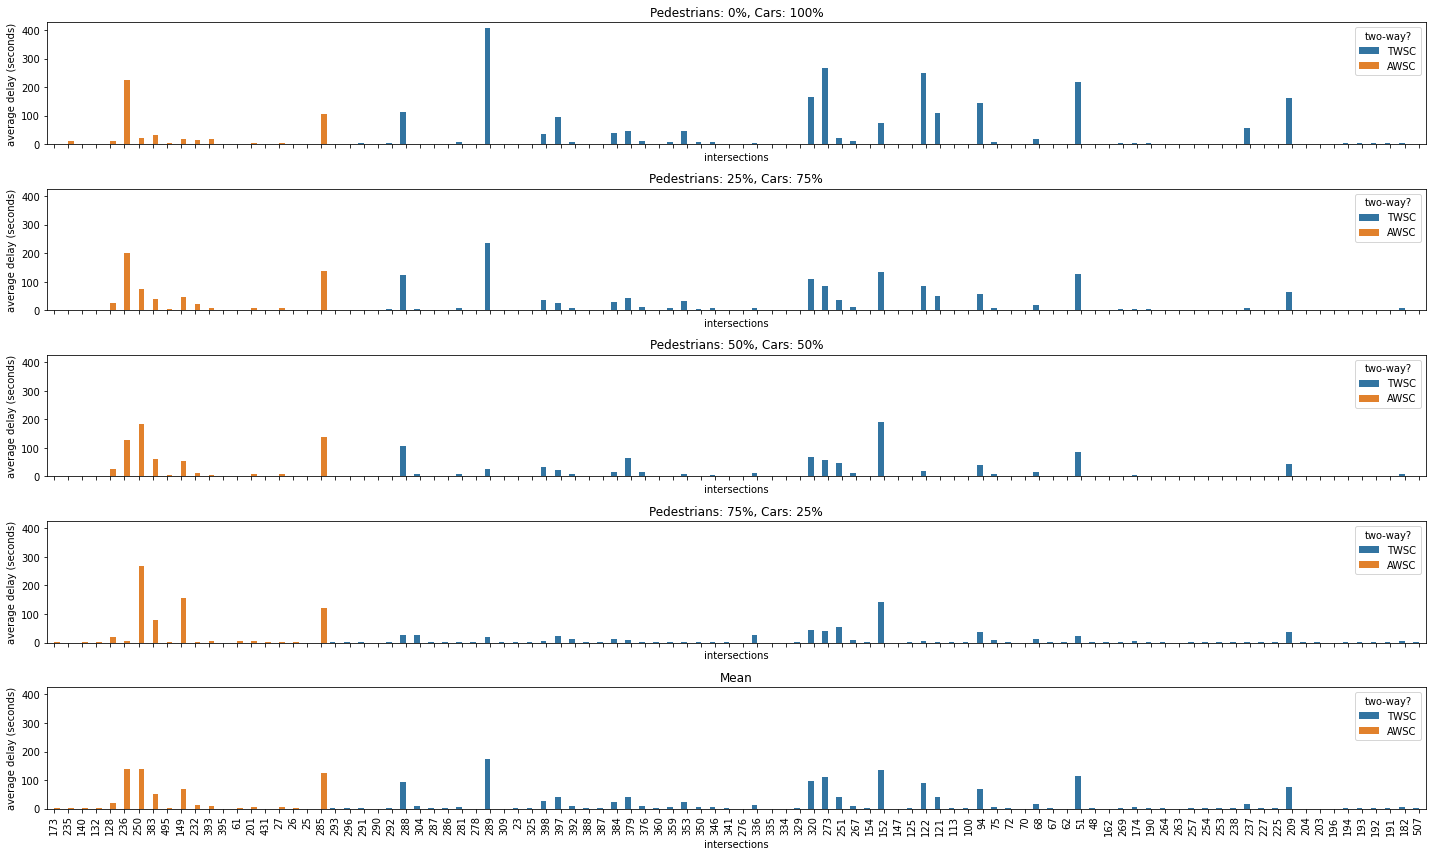

In [236]:
plot_intersection_measure(model, exps[:4])

## Image

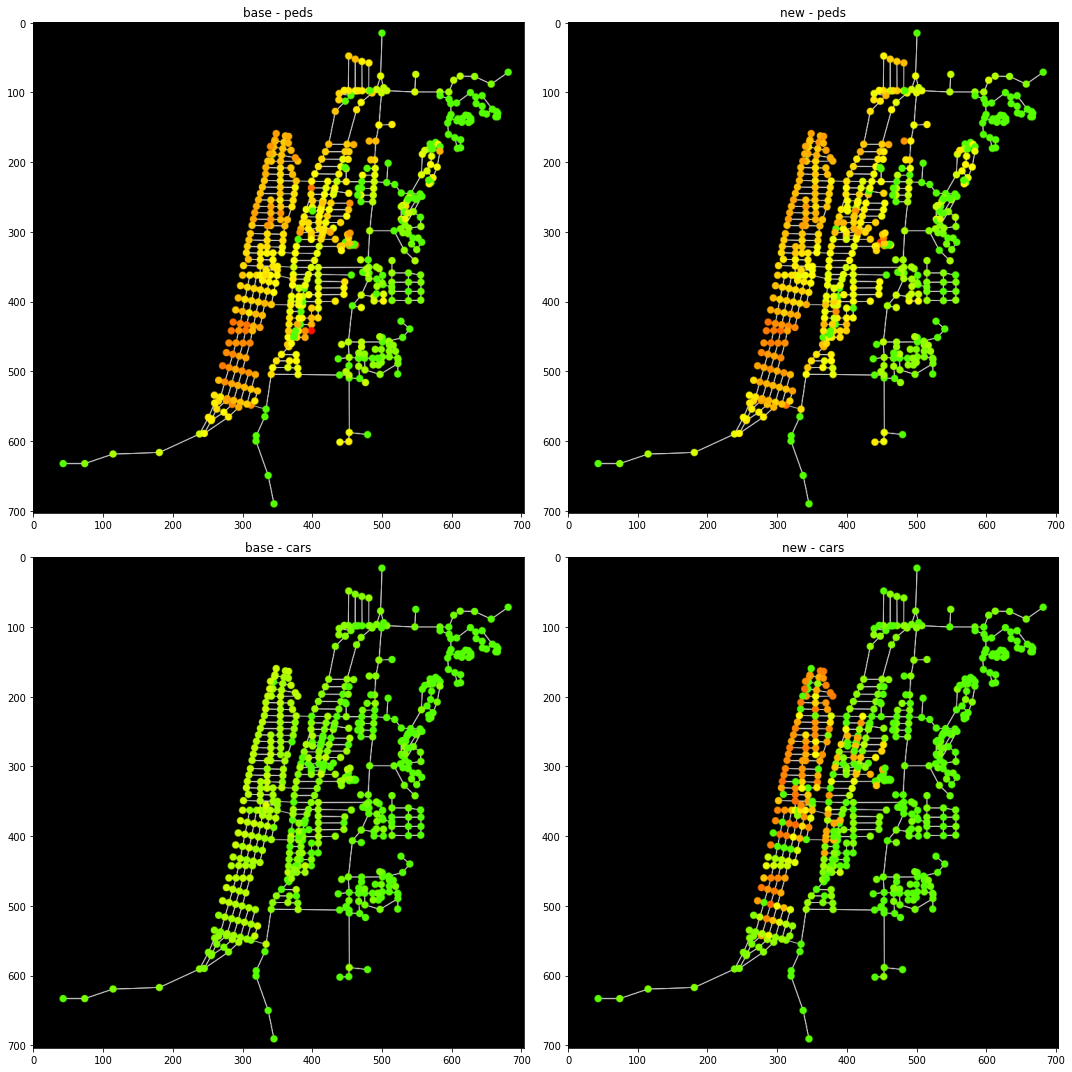

In [266]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for i, mode in enumerate(["peds", "cars"]):
    for j, model in enumerate(models):
        img = plt.imread(f"./images/evacuation_time/{model}/evacuation_time_75_25_{mode}.png")

        axes[i, j].imshow(img)
        axes[i, j].set_title(model + " - " + mode)

fig.tight_layout()

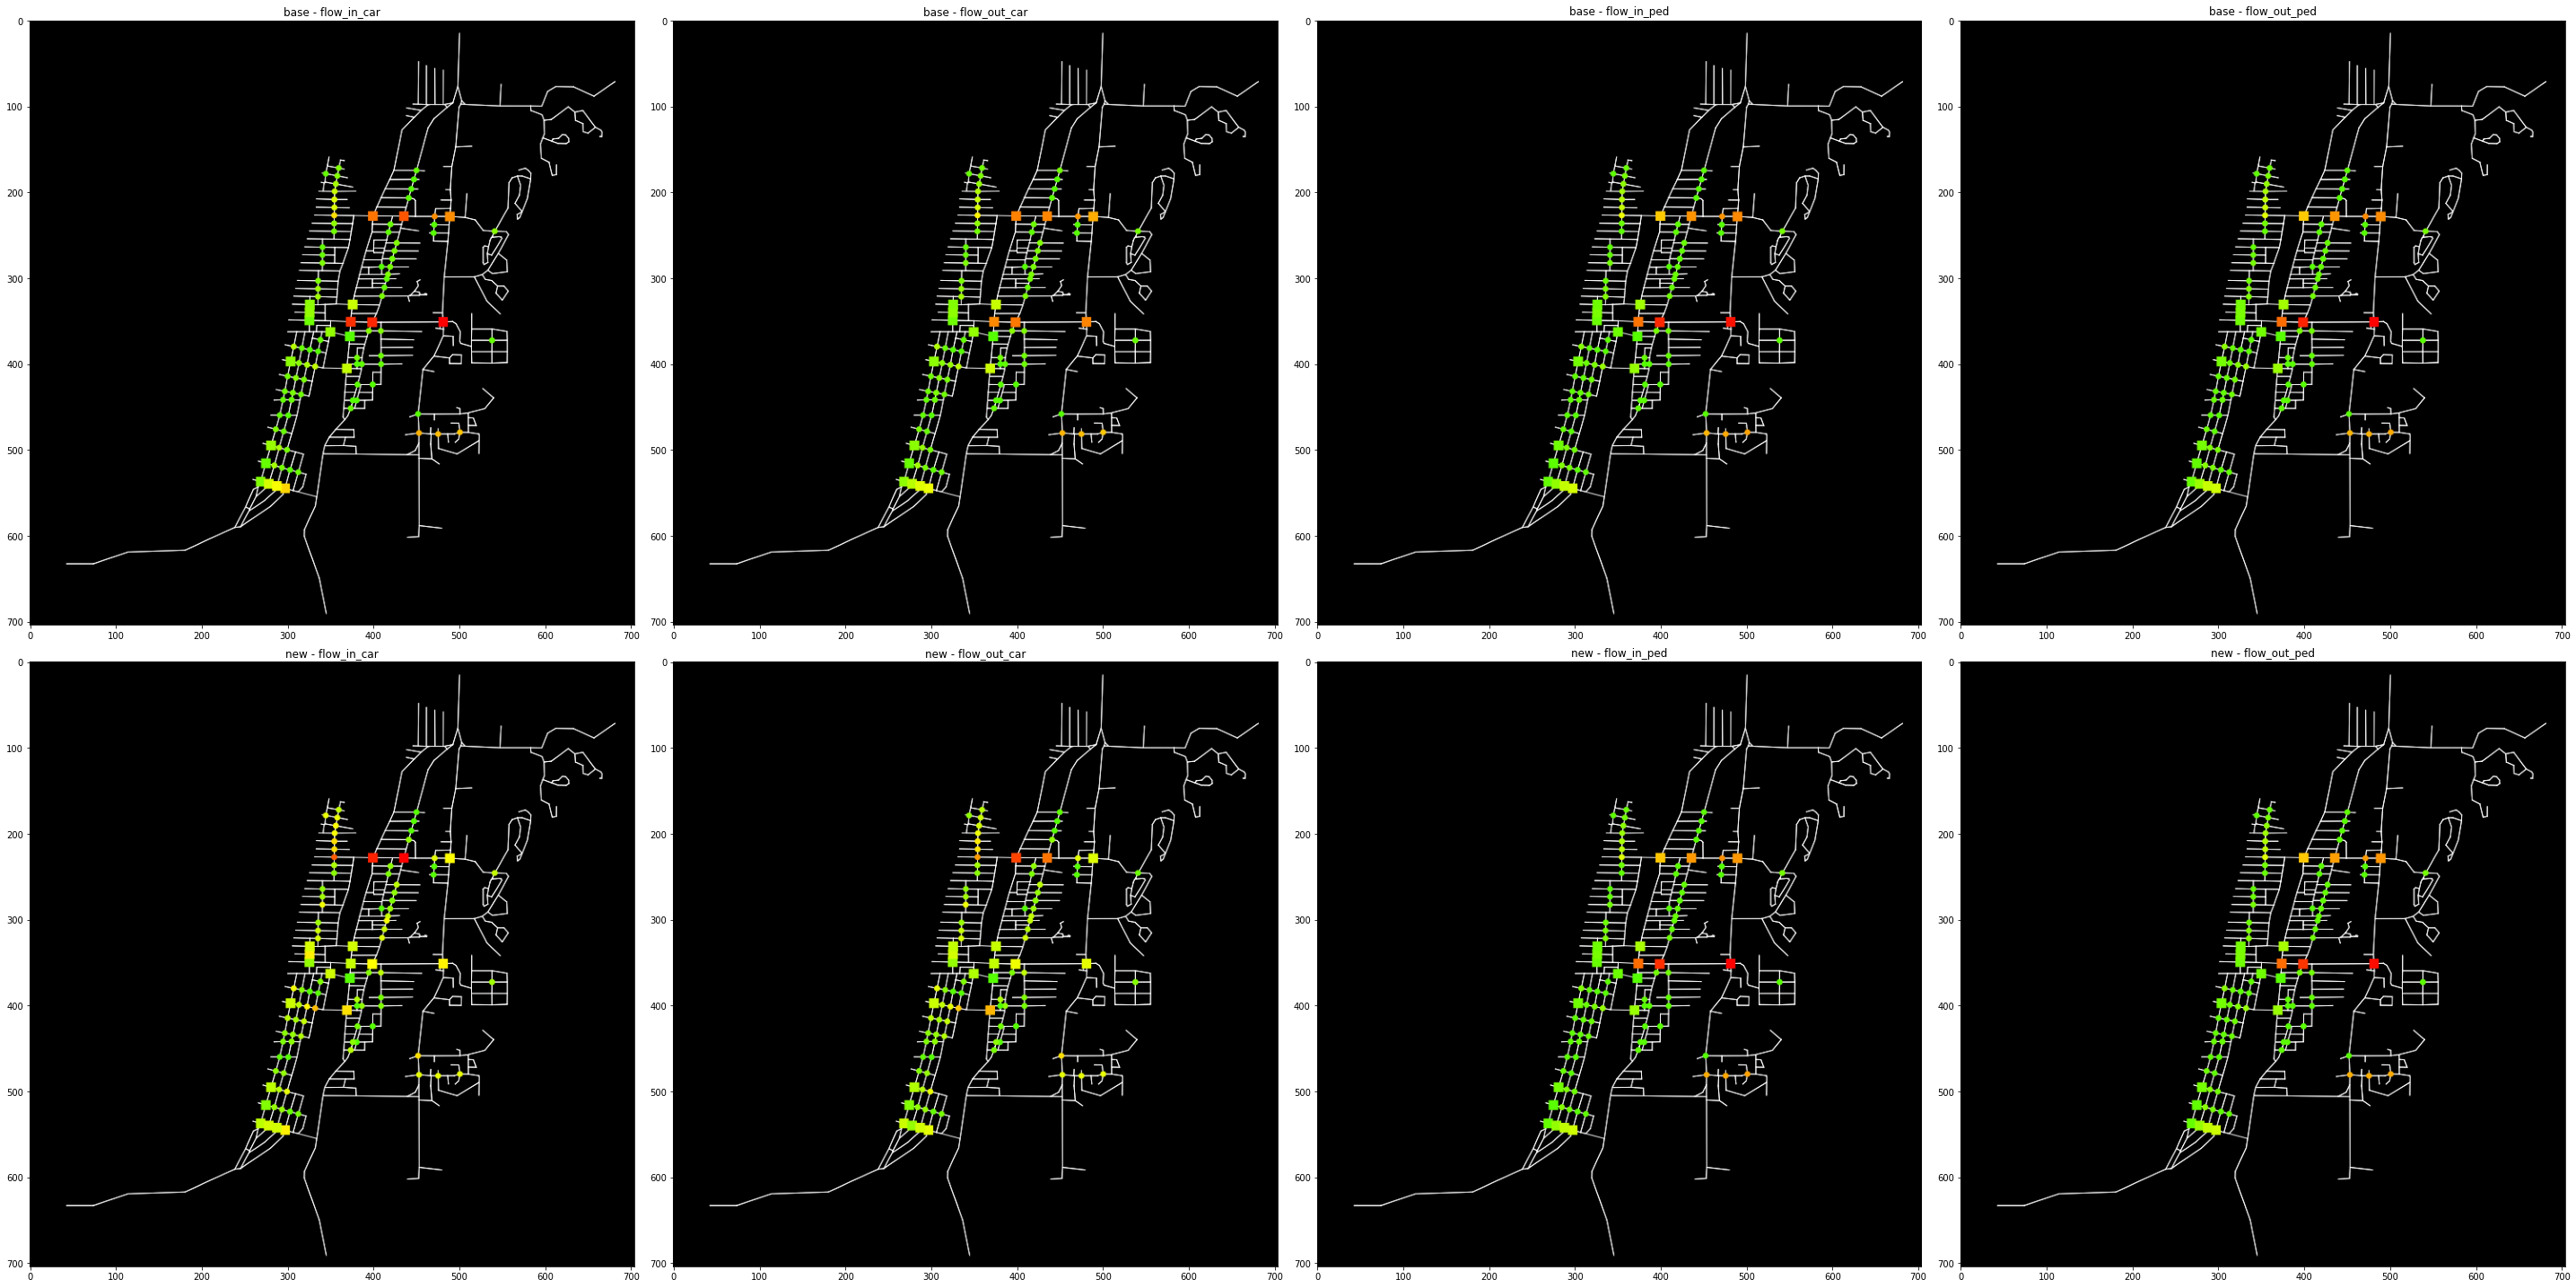

In [258]:
fig, axes = plt.subplots(2, 4, figsize=(40, 20))
models = ["base", "new"]


for i, model in enumerate(models):
    for j, mode in enumerate(["flow_in_car", "flow_out_car", "flow_in_ped", "flow_out_ped"]):
        img = plt.imread(f"./images/flow/{model}/{mode}_75_25.png")

        axes[i, j].imshow(img)
        axes[i, j].set_title(model + " - " + mode)

fig.tight_layout()

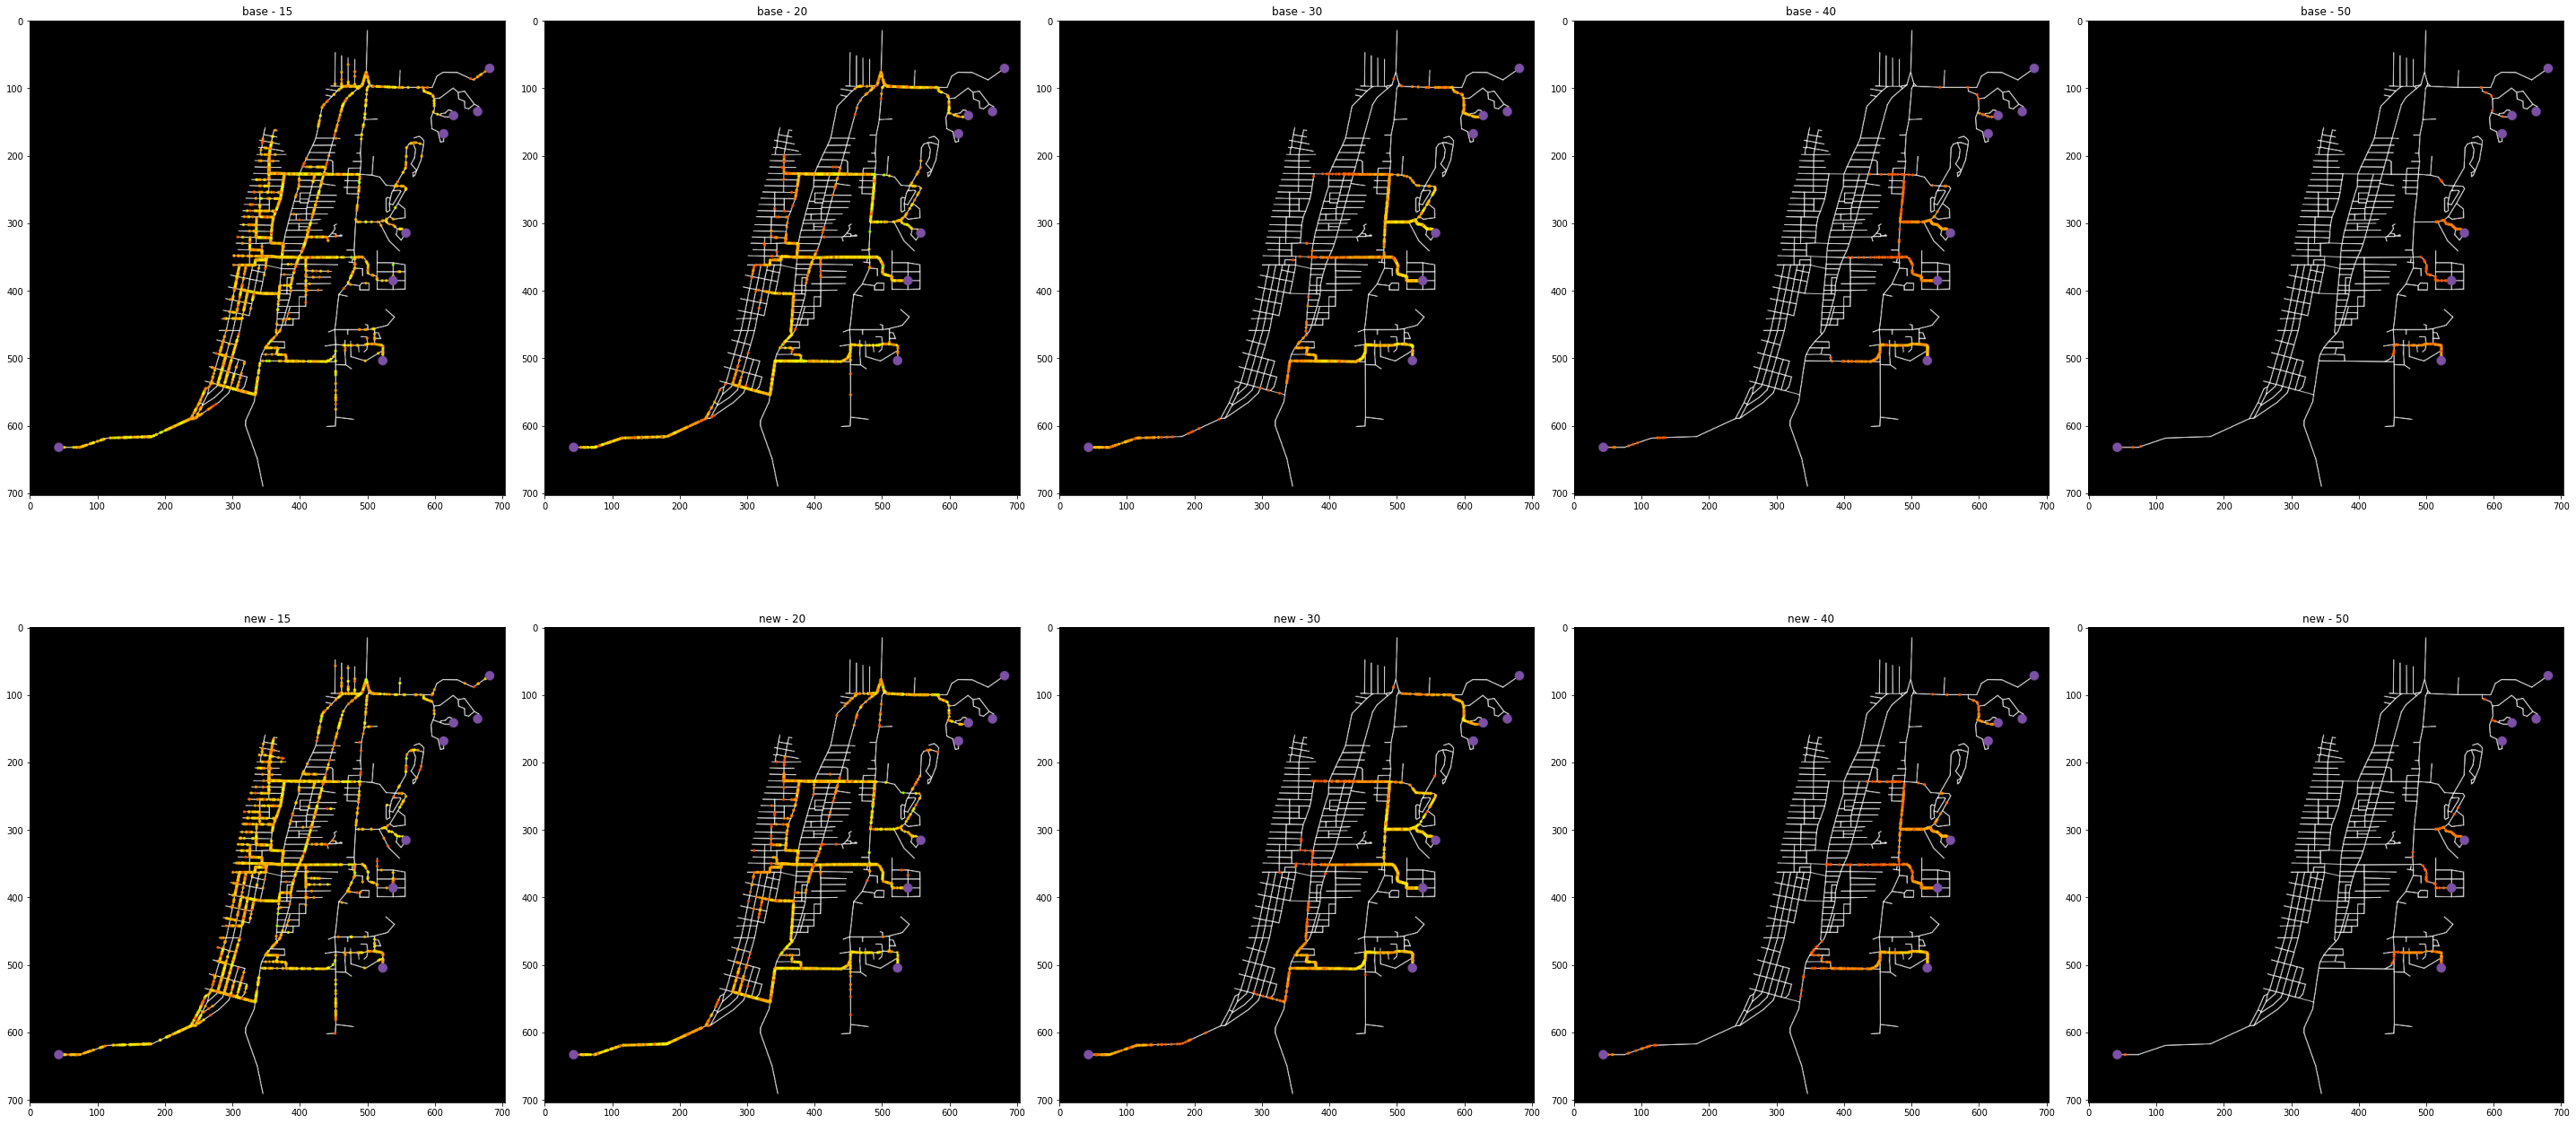

In [263]:
fig, axes = plt.subplots(2, 5, figsize=(40, 20))
models = ["base", "new"]

for i, model in enumerate(models):
    for j, time in enumerate([15, 20, 30, 40, 50]):
        img = plt.imread(f"./images/speeds/{model}/peds/{time}.png")

        axes[i, j].imshow(img)
        axes[i, j].set_title(model + " - " + str(time))

fig.tight_layout()

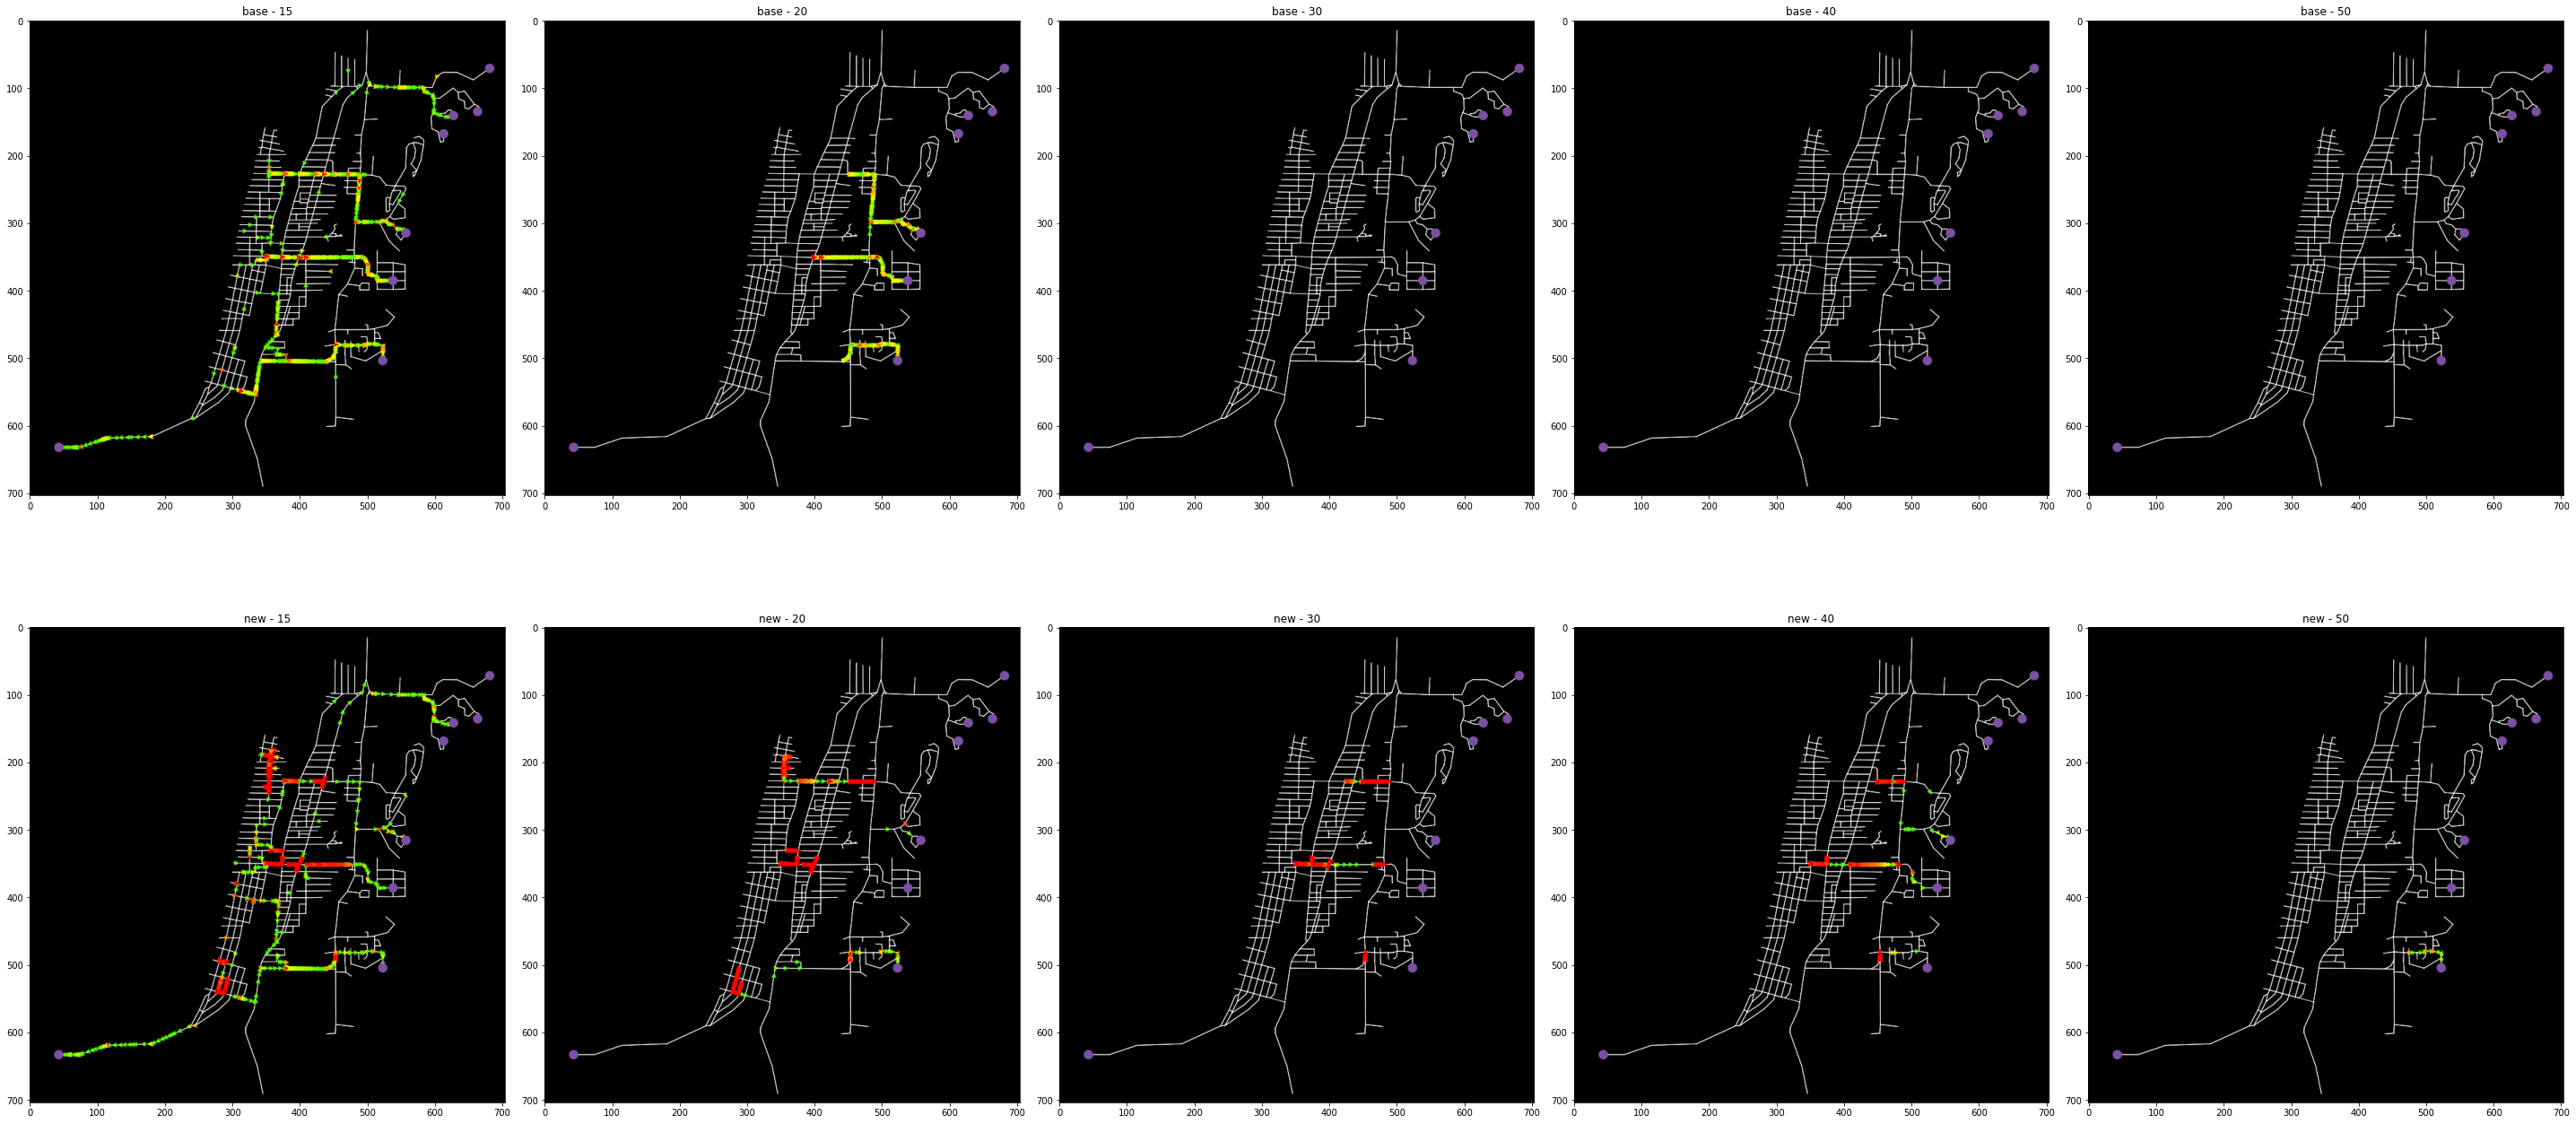

In [260]:
fig, axes = plt.subplots(2, 5, figsize=(40, 20))
models = ["base", "new"]

for i, model in enumerate(models):
    for j, time in enumerate([15, 20, 30, 40, 50]):
        img = plt.imread(f"./images/speeds/{model}/cars/{time}.png")

        axes[i, j].imshow(img)
        axes[i, j].set_title(model + " - " + str(time))

fig.tight_layout()